In [ ]:
import os
from collections import Counter
from itertools import product
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [2]:
from sklearn.svm import SVR

In [ ]:
cox1_df = pd.read_csv(os.path.join(script_dir, '../../csv_files/AMP_species_list_COX1.csv'))
collection_df = pd.read_csv(os.path.join(script_dir, '../../csv_files/AMP_collection_cleaned.csv'))
# cox1_df = pd.read_csv("C:\\Users\\msvhaeve\\OneDrive - UGent\\Desktop\\AMP_species_list_COX1.csv")
# collection_df = pd.read_csv("C:\\Users\\msvhaeve\\OneDrive - UGent\\Desktop\\AMP_collection_cleaned.csv")
collection_df['Species'] = collection_df['Species'].str.replace('_', ' ')
merged_df = pd.merge(cox1_df, collection_df, left_on='ScientificName', right_on='Species', how='inner')

# Filter the DataFrame for the selected description
filtered_df = merged_df[merged_df['Description'] == "weight at birth"]

In [ ]:
# Duplicaten van species verwijderen
filtered_df = filtered_df.drop_duplicates(subset='Species', keep='first')

In [ ]:
# Alle niet-ACTG karakters verwijderen, deze komen slechts een paar keren voor in de sequenties
def filter_sequence(sequence):
    valid_chars = {'A', 'C', 'T', 'G'}
    return ''.join(char for char in sequence if char in valid_chars)

In [6]:
filtered_df.loc[:, "sequentie"] = filtered_df.sequentie.apply(filter_sequence)

In [ ]:
def kmer_count_dataframe(sequences, k):

    # Alle mogelijke kmeren van lengte k genereren (4^k combinaties)
    all_kmers = [''.join(p) for p in product('ACGT', repeat=k)]
    
    # Een lijst initializeren om de k-mer tellingen voor elke sequentie op te slaan
    kmer_counts_list = []
    
    for sequence in sequences:
        # Tel de kmeren die aanwezig zijn in de sequentie
        kmers_in_sequence = (sequence[i:i+k] for i in range(len(sequence) - k + 1))
        kmer_counts = Counter(kmers_in_sequence)
        

        # Creeer een vector met tellingen in de volgorde van alle_kmers
        count_vector = [kmer_counts[kmer] for kmer in all_kmers]
        kmer_counts_list.append(count_vector)
    
    # Maak een DataFrame met kmeren als kolommen en sequenties als rijen
    kmer_df = pd.DataFrame(kmer_counts_list, columns=all_kmers)
    
    return kmer_df

In [ ]:
# Normalizeer de kmer tellingen door de tellingen te delen door de som van de tellingen voor elke sequentie
def normalize_kmer_counts(df: pd.DataFrame) -> pd.DataFrame:
    total_counts = df.sum(axis=1)
    normalized_df = df.div(total_counts, axis=0)
    return normalized_df

In [9]:
y = np.log(filtered_df['Observed'])

In [ ]:
results = []
mean_training_scores = []  # To store training R^2 scores
mean_validation_scores = []  # To store validation R^2 scores
kmer_lengths = [2, 3, 4, 5,6,7,8]

In [ ]:
# Loop through k-mer lengths from 2 to 6
for k in kmer_lengths:
    print(f"Processing k-mer length: {k}")
    
    X = kmer_count_dataframe(filtered_df.loc[:, "sequentie"].values, k)
    X = normalize_kmer_counts(X)
    # Perform cross-validation
    kf = KFold(n_splits=10, shuffle=True)
    training_scores = []  # To store training R^2 for each fold
    validation_scores = []  # To store validation R^2 for each fold
    
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Een eenvoudiger model gebruiken voor de regressie
        model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
        model.fit(X_train, y_train)

        # Calculate training R^2
        training_r2 = model.score(X_train, y_train)
        training_scores.append(training_r2)

        # Calculate validation R^2
        validation_r2 = model.score(X_test, y_test)
        validation_scores.append(validation_r2)

    # Store the mean training and validation R^2 for this k-mer length
    mean_training_scores.append(np.mean(training_scores))
    mean_validation_scores.append(np.mean(validation_scores))

    # Store the results
    results.append({
        'k-mer Length': k,
        'Training R^2': np.mean(training_scores),
        'Validation R^2': np.mean(validation_scores),
        'Data Count': len(X)
    })

Processing k-mer length: 2
Processing k-mer length: 3
Processing k-mer length: 4
Processing k-mer length: 5
Processing k-mer length: 6
Processing k-mer length: 7
Processing k-mer length: 8


   k-mer Length  Training R^2  Validation R^2  Data Count
0             2      0.633563        0.622278        1594
1             3      0.732290        0.712725        1594
2             4      0.792095        0.760802        1594
3             5      0.831728        0.781158        1594
4             6      0.832606        0.768427        1594
5             7      0.809104        0.730735        1594
6             8      0.770268        0.676176        1594


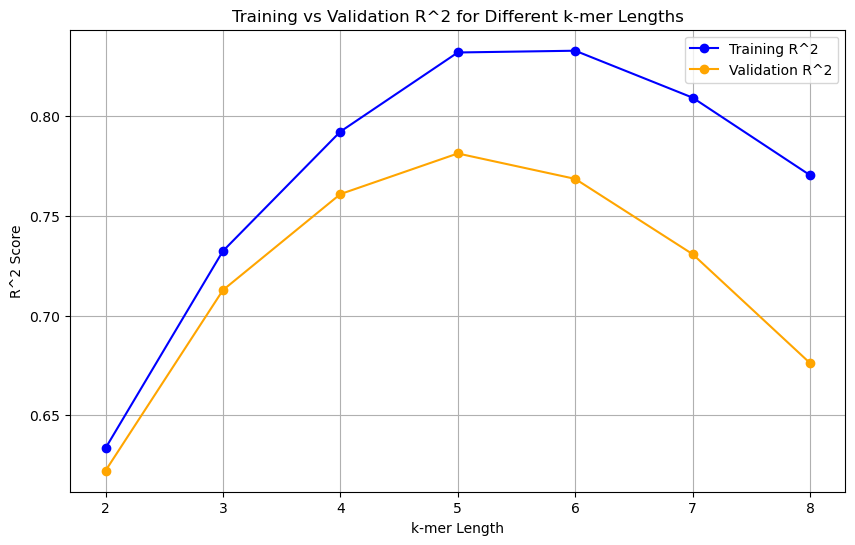

In [20]:
# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Plot training vs validation R^2
plt.figure(figsize=(10, 6))
plt.plot(results_df['k-mer Length'], results_df['Training R^2'], label='Training R^2', marker='o', color='blue')
plt.plot(results_df['k-mer Length'], results_df['Validation R^2'], label='Validation R^2', marker='o', color='orange')
plt.title('Training vs Validation R^2 for Different k-mer Lengths')
plt.xlabel('k-mer Length')
plt.ylabel('R^2 Score')
plt.legend()
plt.grid()
plt.show()

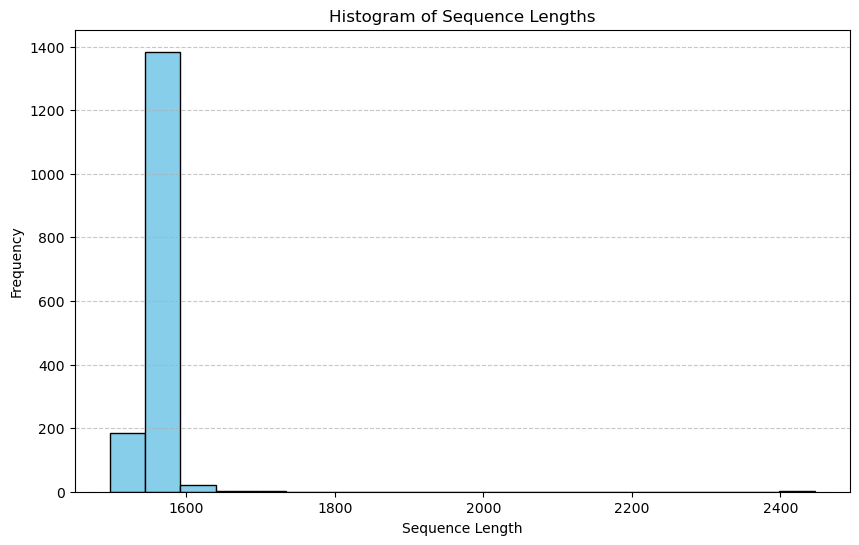

In [ ]:
# Er zit een beetje variatie in de sequentielengtess, de kmer counts worden dus best genormaliseerd.
sequence_lengths = filtered_df["sequentie"].apply(len)

# Histogram van sequentielengtes
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()